In [7]:

import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from functions import simulate_counts, plotsigs
from egpm import EGPM
from optuna_opt import optuna_tune

In [8]:
class EGD(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        # Building an linear encoder
        # 96 => dim1
        self.enc1 = torch.nn.Linear(96, dim1, bias = False)
          
        # Building an linear decoder 
        # dim1 ==> 96
        self.dec1 = torch.nn.Linear(dim1, 96, bias = False)

    def forward(self, x):
        x = torch.nn.functional.relu(self.enc1(x))
        x = self.dec1(x)
        return x

    # Model Initialization
                                
def train_EGD(epochs, model, x_train, loss_function, optimizer_enc, 
                optimizer_dec, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    loss_list = []
    for epoch in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        loss_p = 0
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)
          loss_p =+ loss.item()

          optimizer_enc.zero_grad() #clear old gradients
          optimizer_dec.zero_grad()
          
          loss.backward() #backpropagation
          
          optimizer_enc.step()#update params
          optimizer_dec.step()

        loss_list.append(loss_p)

    plt.plot(range(epochs), loss_list)
    plt.show() 
    return(model)

In [9]:
nsigs = 5

mf_df, true_sigs,_ = simulate_counts(nsigs, 5000, pentanucelotide = False)
trinucleotide = mf_df.index
mutation = [t[2:5] for t in trinucleotide]

X = mf_df.T

#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

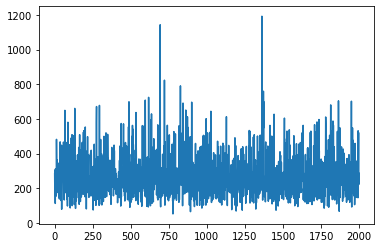

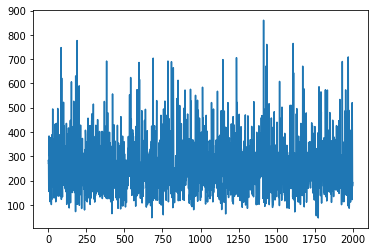

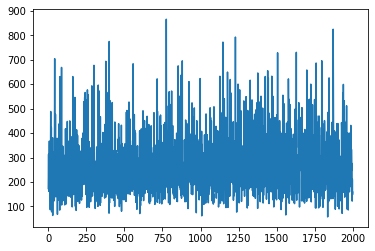

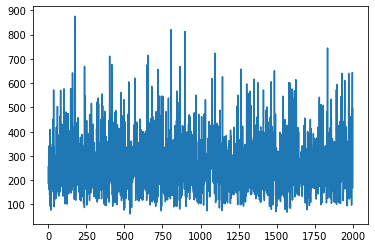

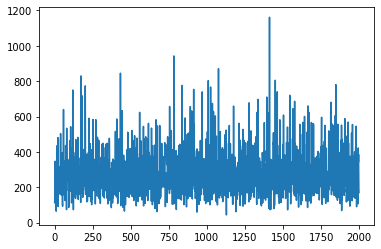

In [ ]:
params = optuna_tune(X, 5)

In [ ]:
params

{'lr': 0.030648753081432948, 'batch_size': 16}

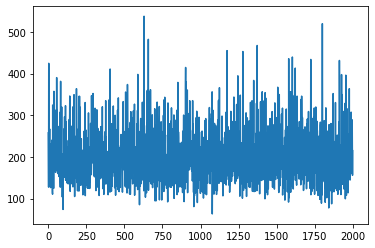

In [ ]:
#choosing the 'true' number of signatures
model = EGD(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_enc = torch.optim.Adam(model.enc1.parameters(), lr = 1e-3)

optimizer_dec =  torch.optim.RMSprop(model.enc1.parameters(), lr = 1e-3)

#EGPM(model.dec1.parameters(), lr = 0.1 , u_scaling=100, 
                       #norm_per=None, gradient_clipping=True, 
                       #weight_regularization=None,plus_minus=False,
                       #init='bootstrap')
                            
train_EGD(epochs = 2000, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer_enc = optimizer_enc,
            optimizer_dec = optimizer_dec,
            batch_size = 32)

#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

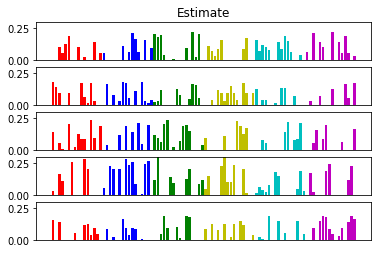

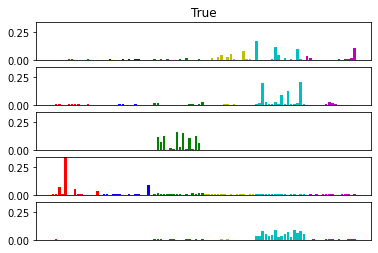

In [ ]:
plotsigs(trinucleotide, mutation, sigs.to_numpy(), 5, "Estimate")
plotsigs(trinucleotide, mutation, true_sigs.to_numpy(), 5, "True")